<a href="https://colab.research.google.com/github/CSpanias/ml_training/blob/master/DecisionTreeClassifier_diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Decision Tree Classifier Algorithm**

*This notebook was developed for Decision Tree practice and the resulting code is a blend of various different resources.*

Based mostly on:
* [SoloLearn Courses (ML Path)](https://www.sololearn.com/learning/1094)



# **CONTENT**

1. [Data Cleaning](#DataCleaning)
2. [Exploratory Data Analysis (EDA)](#EDA)
2. [KFold Cross-Validation with different criterion (gini, entropy)](#KFold)
3. [Decision Tree Visualization (GraphViz)](#GraphViz)
4. [Pruning the Decision Tree](#Pruning)
  * [Pre-Pruning](#Pre-Pruning)
  * [Post-Pruning](#Post-Pruning)
5. [Conclusions](#Conclusions)


In [48]:
import pandas as pd # importing dataset as a "spreadsheet"
import numpy as np # convert DataFrame to arrays, calculate means
import seaborn as sns # visualization
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier # algorithm required
from sklearn.model_selection import train_test_split # split data
from sklearn.model_selection import KFold, cross_val_score # perform a KFold Cross-Validation
from sklearn.metrics import accuracy_score, precision_score, recall_score # evaluation metrics

In [11]:
# make a list of headers for the dataset
col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree',
    'age', 'label']

# read the CSV file, ignore the top row, and use the above headers
df = pd.read_csv('https://raw.githubusercontent.com/CSpanias/ml_training/master/diabetes.csv',
                 skiprows = 1, names=col_names)

# print the first 5 rows of data
df.head()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [12]:
# print info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pregnant  768 non-null    int64  
 1   glucose   768 non-null    int64  
 2   bp        768 non-null    int64  
 3   skin      768 non-null    int64  
 4   insulin   768 non-null    int64  
 5   bmi       768 non-null    float64
 6   pedigree  768 non-null    float64
 7   age       768 non-null    int64  
 8   label     768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [13]:
# check how many target classes there are
print(df['label'].unique())

[1 0]


<a name="DataCleaning"> </a>
# **Data Cleaning**

* Missing values
* Duplicate rows

In [14]:
# check for missing values
df.isna().sum()

pregnant    0
glucose     0
bp          0
skin        0
insulin     0
bmi         0
pedigree    0
age         0
label       0
dtype: int64

In [15]:
# check for duplicates
df.duplicated().sum()

0

<a name="EDA"> </a>
# **Exploratory data analysis (EDA)**
  * Heatmap
  * Pairplot
  * Correlation table

The aim is to explore if any pair(s) of variables has a strong linear relationship (**multi-collinearity**), as if they do they tend to cancel each other out. Hence, we might choose either to combine them into one or just discard one of them and keep the other.

The final goal (ideally) is to **avoid multi-collinearity**; all independent variables (Xs) to be correlated with the dependent variable (y), but not with each other!

Explore the relationships with a **correlation table**: 
* The default method is **Pearson** (r). 
* The closer to one, the stronger the relationship.

More info [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html).

In [33]:
# print a table with all variables' correlations
df.corr()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
pregnant,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
bp,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
skin,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
bmi,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
pedigree,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
label,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


**HeatMap** is essentially a more visual way of looking at a correlation table:

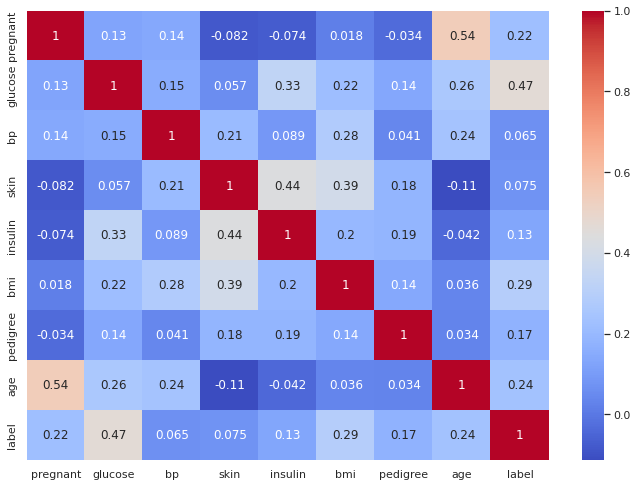

In [39]:
# set figure size
sns.set(rc={'figure.figsize':(11.7,8.27)})
# generate a heatmap
sns.heatmap(df.corr(), annot=True,cmap='coolwarm')

Explore the invidual relationship of each variable pair with **pairplots**:  
(*in this case it does not help much, as there are too many variables*)

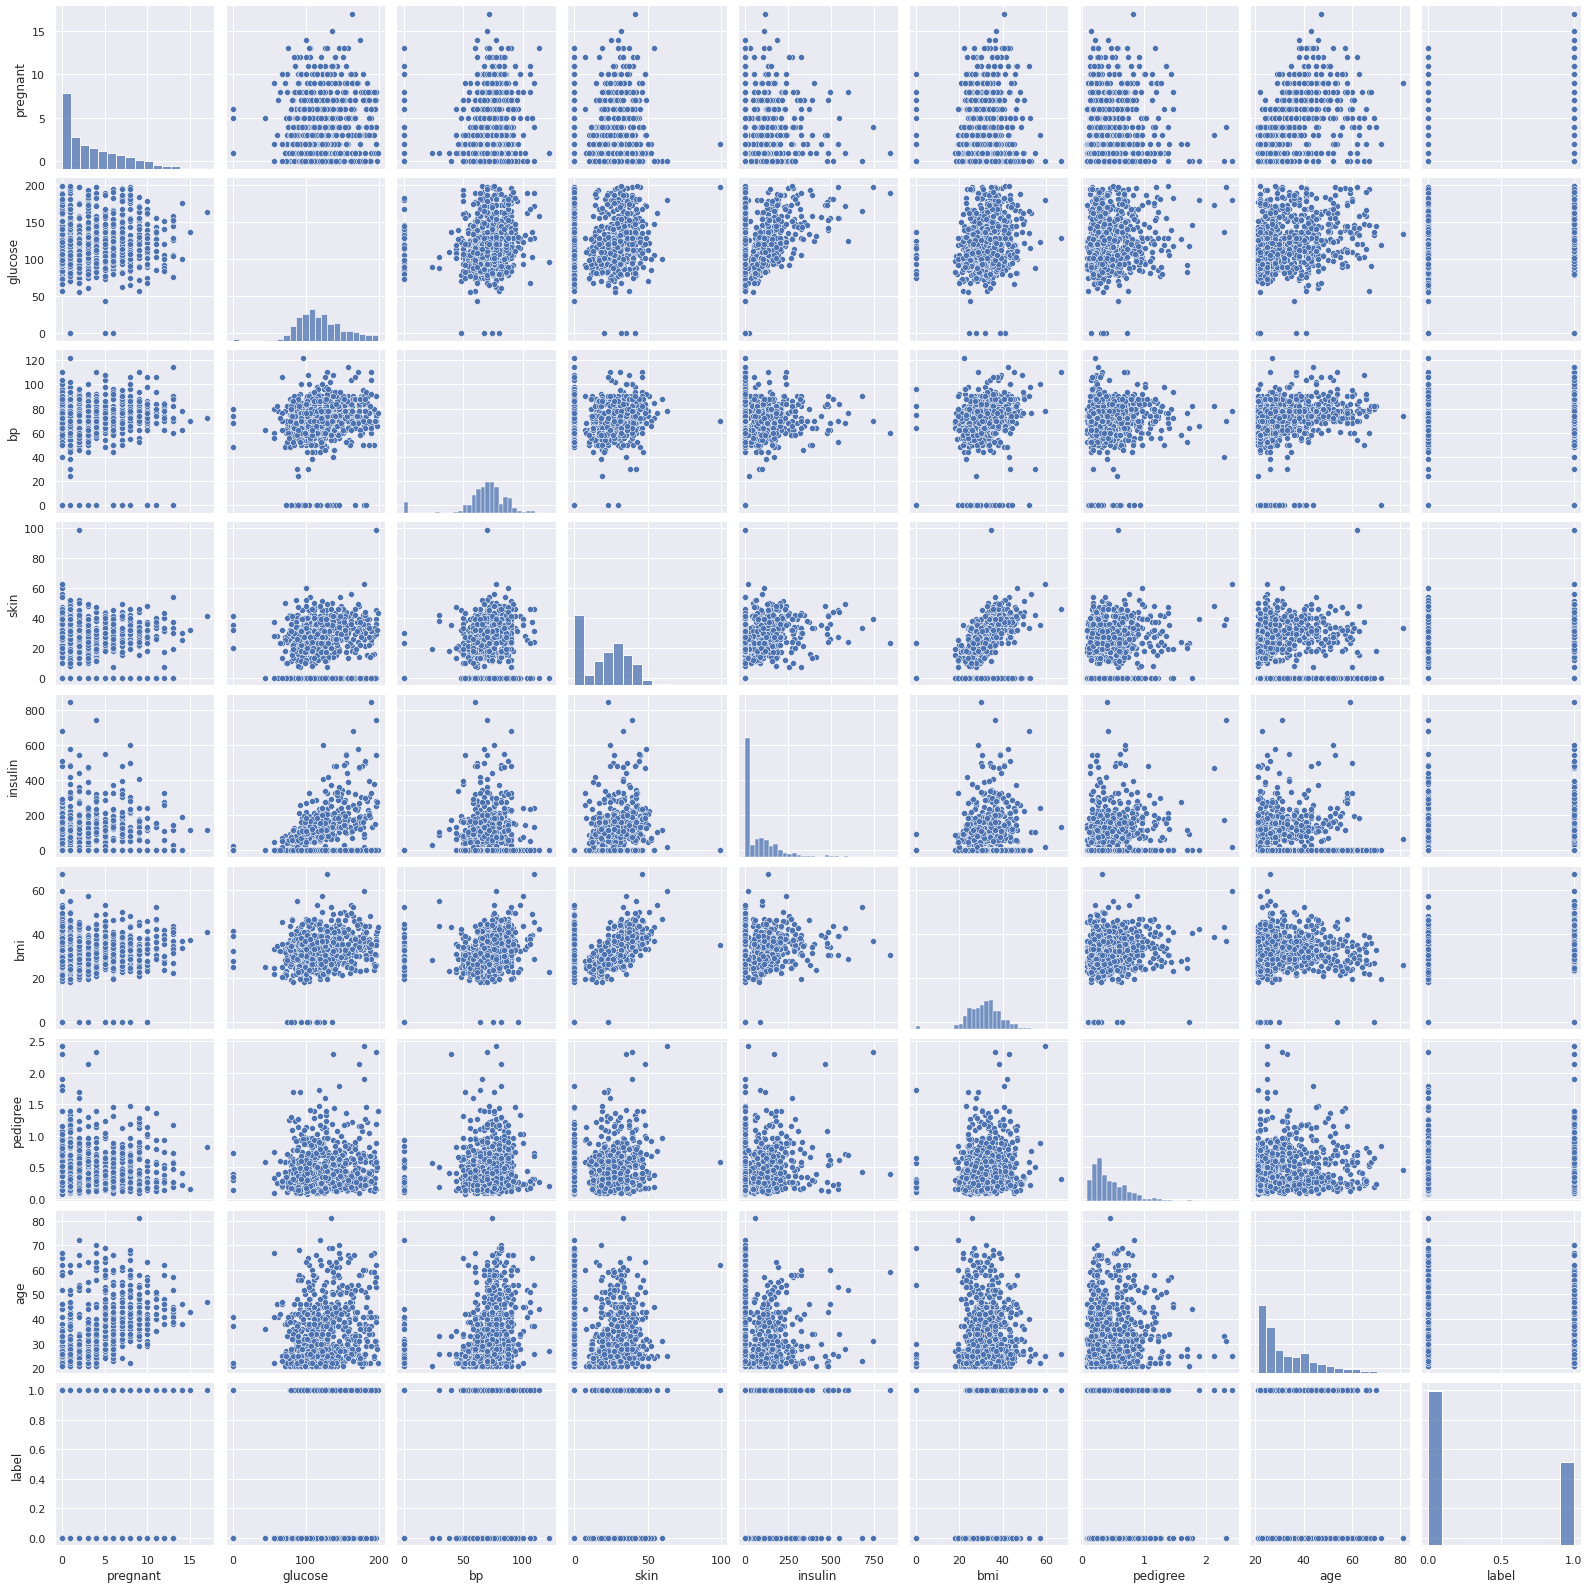

In [41]:
# set figure size
sns.set(rc={'figure.figsize':(5,5)})
sns.pairplot(df)

<a name='KFold'> </a>
 # **KFold Cross Validation with different criterion** (gini, entropy)

1. Assign Xs (features) & y (target) 
2. Convert them from pandas DataFrame (matrix) and pandas Series (single column) to ***numpy 2- and 1-Dimensional numpy arrays***, respectively.

  Pandas DataFrames & Series are easier to read by a human, but numpy's arrays are ***easier to handled by the computer***.  

In [145]:
# from df drop the specified variable, axis=1: drop the whole column
X = df.drop(columns='label', axis=1)
# convert pandas dataframe to a 2-Dimensional numpy array
X = X.values
# confirm that X's shape is 2D
print(X.shape)

# assing target
y = df['label']
# convert pandas series to a 1-Dimensional numpy array
y = y.values
# confirm that y's shape is 1D
print(y.shape)

(768, 8)
(768,)


Perform KFold Cross-Validation to compare the mean accuracy of:
1. A Decision Tree model with gini as the criterion.
2. A Decision Tree model with entropy as the criterion.

In [140]:
# define the number of splits (train/test sets) and shuffle rows
kf = KFold(n_splits=5, shuffle=True, random_state=44)

In [146]:
# perform a KFold CV using gini
print("Perform a KFold CV using gini:\n")
model = DecisionTreeClassifier(criterion='gini')
# calculate the accuracy score of each of the 5 train/test sets
model_scores = cross_val_score(model, X, y, scoring='accuracy', cv=kf,
                               verbose=3)
# print average cross-validation score with default parameteres
print('\nMean\u00B1std stratified cross-validation score: {:.3f}\u00B1{:.2f}\n' 
      .format(model_scores.mean(), model_scores.std()))

# perform a KFold CV using entropy
print("Perform a KFold CV using entropy:\n")
model = DecisionTreeClassifier(criterion='entropy')
# calculate the accuracy score of each of the 5 train/test sets
model_scores = cross_val_score(model, X, y, scoring='accuracy', cv=kf,
                               verbose=3)
# print average cross-validation score with default parameteres
print('\nMean\u00B1std stratified cross-validation score: {:.3f}\u00B1{:.2f}\n' 
      .format(model_scores.mean(), model_scores.std()))

Perform a KFold CV using gini:

[CV] END ................................ score: (test=0.766) total time=   0.0s
[CV] END ................................ score: (test=0.695) total time=   0.0s
[CV] END ................................ score: (test=0.740) total time=   0.0s
[CV] END ................................ score: (test=0.667) total time=   0.0s
[CV] END ................................ score: (test=0.667) total time=   0.0s

Mean±std stratified cross-validation score: 0.707±0.04

Perform a KFold CV using entropy:

[CV] END ................................ score: (test=0.766) total time=   0.0s
[CV] END ................................ score: (test=0.656) total time=   0.0s
[CV] END ................................ score: (test=0.740) total time=   0.0s
[CV] END ................................ score: (test=0.654) total time=   0.0s
[CV] END ................................ score: (test=0.739) total time=   0.0s

Mean±std stratified cross-validation score: 0.711±0.05



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


There is almost no difference between gini vs. entropy, but this is to be expected.  

More info on **gini vs. entropy** [here](https://quantdare.com/decision-trees-gini-vs-entropy/).

<a name='Pruning'> </a>
# **Pruning the Decision Tree**
Removing the unnecessary elements from the Decision Trees with the aim of:
* Reducing the complexity to avoid overfitting
* Making it easier to interpret.



1. **Pre-Pruning**: the goal is to limit tree growth
  * ***max_depth***: grow up to a certain depth/height
  * ***min_samples_split***: the minimun number of samples required to split an internal node.
  * ***max_leaf_nodes***: limit the total number of leaf nodes allowed in the tree

    Additional info [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

2. **Post-pruning**: build the whole tree and then review the tree and decide which leaves to remove to make it smaller.

<a name='Pre-Pruning'> </a>
## **Pre-Pruning** example:

In [164]:
# create the model with modified parameters
model = DecisionTreeClassifier(criterion='entropy',
                               max_depth=10,
                               min_samples_split=4,
                               max_leaf_nodes=20,)

# train the model
model.fit(X_train, y_train)

# predict using the training data
y_pred_train = model.predict(X_train)
# predict using the test data
y_pred = model.predict(X_test)
# print accuracy
print("Training Accuracy: {:.4f}" .format(accuracy_score(y_train, y_pred_train)))
print("Testing Accuracy: {:.4f}" .format(accuracy_score(y_test, y_pred)))

Training Accuracy: 0.8274
Testing Accuracy: 0.7403


<a name='GraphViz'> </a>
## **Decision Tree Visualization** (GraphViz)

Decision Trees benefits:
1. **Interpretability**: clarity of information representation, useful for explaining the prediction to a non-technical audience.
2. **Transparency**: can greatly help in the *decision making process*. 

*If you're going to run this on your computer, make sure to install graphviz first. You can do this by opening your command prompt and typing "**pip install graphviz**".*

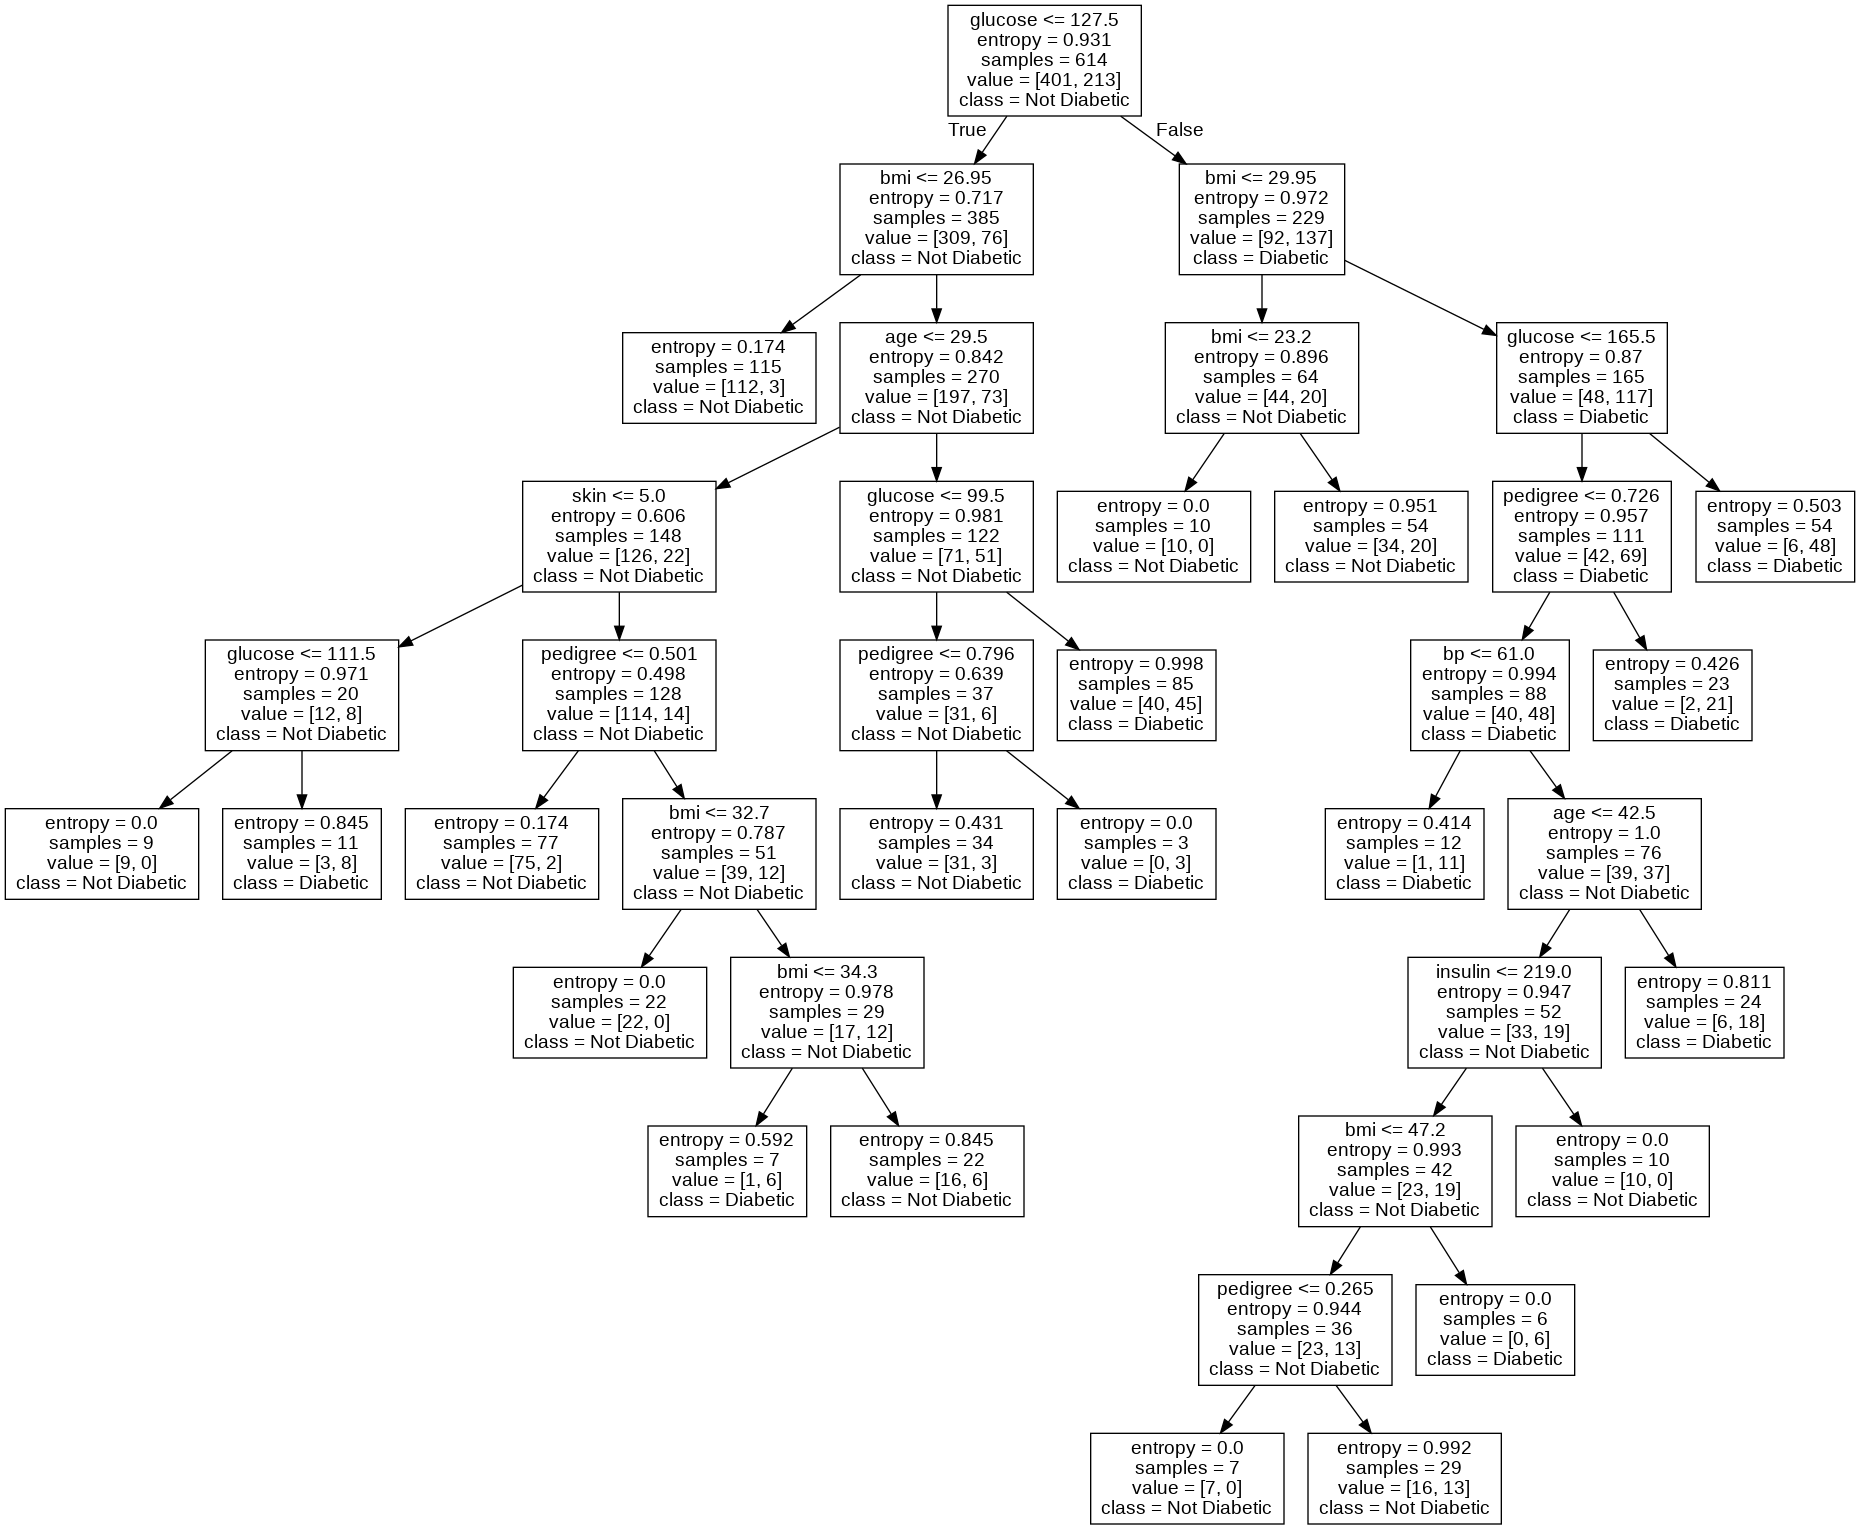

In [165]:
# import export_graphviz
from sklearn.tree import export_graphviz
# export files as stored as .dot files
dot_file = export_graphviz(model, feature_names=feature_names,
                           class_names= ['Not Diabetic', 'Diabetic'])

# import graphviz to convert .dot file to a .png image
import graphviz
# read the dot_file
graph = graphviz.Source(dot_file)
# convert .dot to .png without generating additional files
graph.render(filename='tree_diabetes', format='png', cleanup=True)

# import IPython to display the rendered .png image
from IPython.display import Image
# display image using the path
Image(filename="/content/tree_diabetes.png")

Pre-Prunning successfully ***increased testing accuracy*** in comparison to the default model (71% vs. 74%)

<a name='Post-Pruning'> </a>
## **Post-Pruning** example:

In [166]:
# create the model
model = DecisionTreeClassifier(criterion='entropy')

# train the model
model.fit(X_train, y_train)

# predict using the training data
y_pred_train = model.predict(X_train)
# predict using the test data
y_pred = model.predict(X_test)
# print accuracy
print("Training Accuracy: {:.4f}" .format(accuracy_score(y_train, y_pred_train)))
print("Testing Accuracy: {:.4f}" .format(accuracy_score(y_test, y_pred)))

Training Accuracy: 1.0000
Testing Accuracy: 0.7208


Visualize the full Decision Tree:

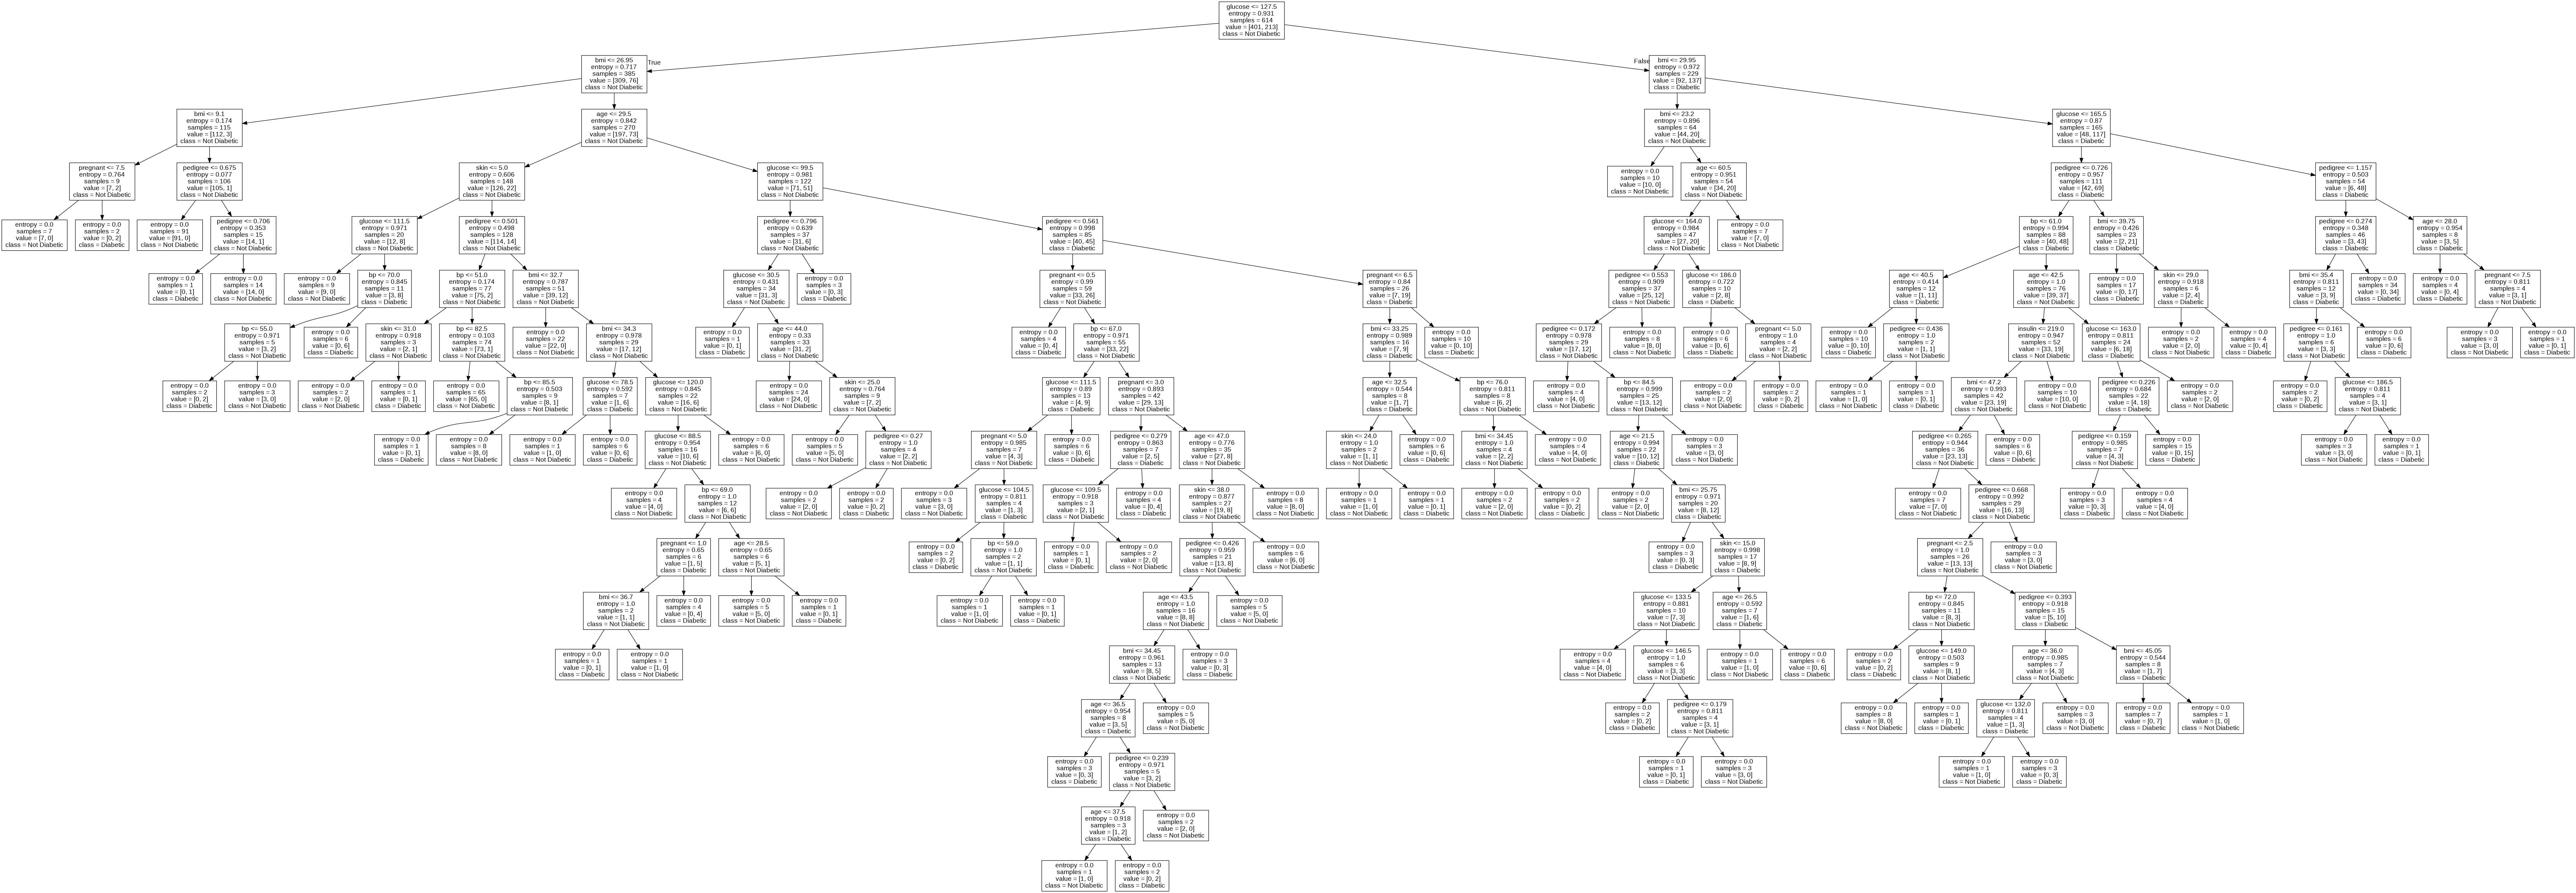

In [167]:
# import export_graphviz
from sklearn.tree import export_graphviz
# export files as stored as .dot files
dot_file = export_graphviz(model, feature_names=feature_names,
                           class_names= ['Not Diabetic', 'Diabetic'])

# import graphviz to convert .dot file to a .png image
import graphviz
# read the dot_file
graph = graphviz.Source(dot_file)
# convert .dot to .png without generating additional files
graph.render(filename='tree_diabetes', format='png', cleanup=True)

# import IPython to display the rendered .png image
from IPython.display import Image
# display image using the path
Image(filename="/content/tree_diabetes.png")

***Testing accuracy dropped*** in comparison with the Pre-Prunned tree (0.72 vs. 0.74).  

The full tree has now ***17 rows*** which results in an ***overfitting*** indication:  *the training accuracy score (100%) is much higher that the testing accuracy score (72%)*.

Notice that, for example, in the ***7th row*** entropy scores are quite good, so try and stop tree growth there and see what happens.

In [168]:
# create the model with modified parameters
model = DecisionTreeClassifier(criterion='entropy',
                               max_depth=7)

# train the model
model.fit(X_train, y_train)

# predict using the training data
y_pred_train = model.predict(X_train)
# predict using the test data
y_pred = model.predict(X_test)
# print accuracy
print("Training Accuracy: {:.4f}" .format(accuracy_score(y_train, y_pred_train)))
print("Testing Accuracy: {:.4f}" .format(accuracy_score(y_test, y_pred)))

Training Accuracy: 0.8925
Testing Accuracy: 0.7597


Visualize the Post-Prunned tree:

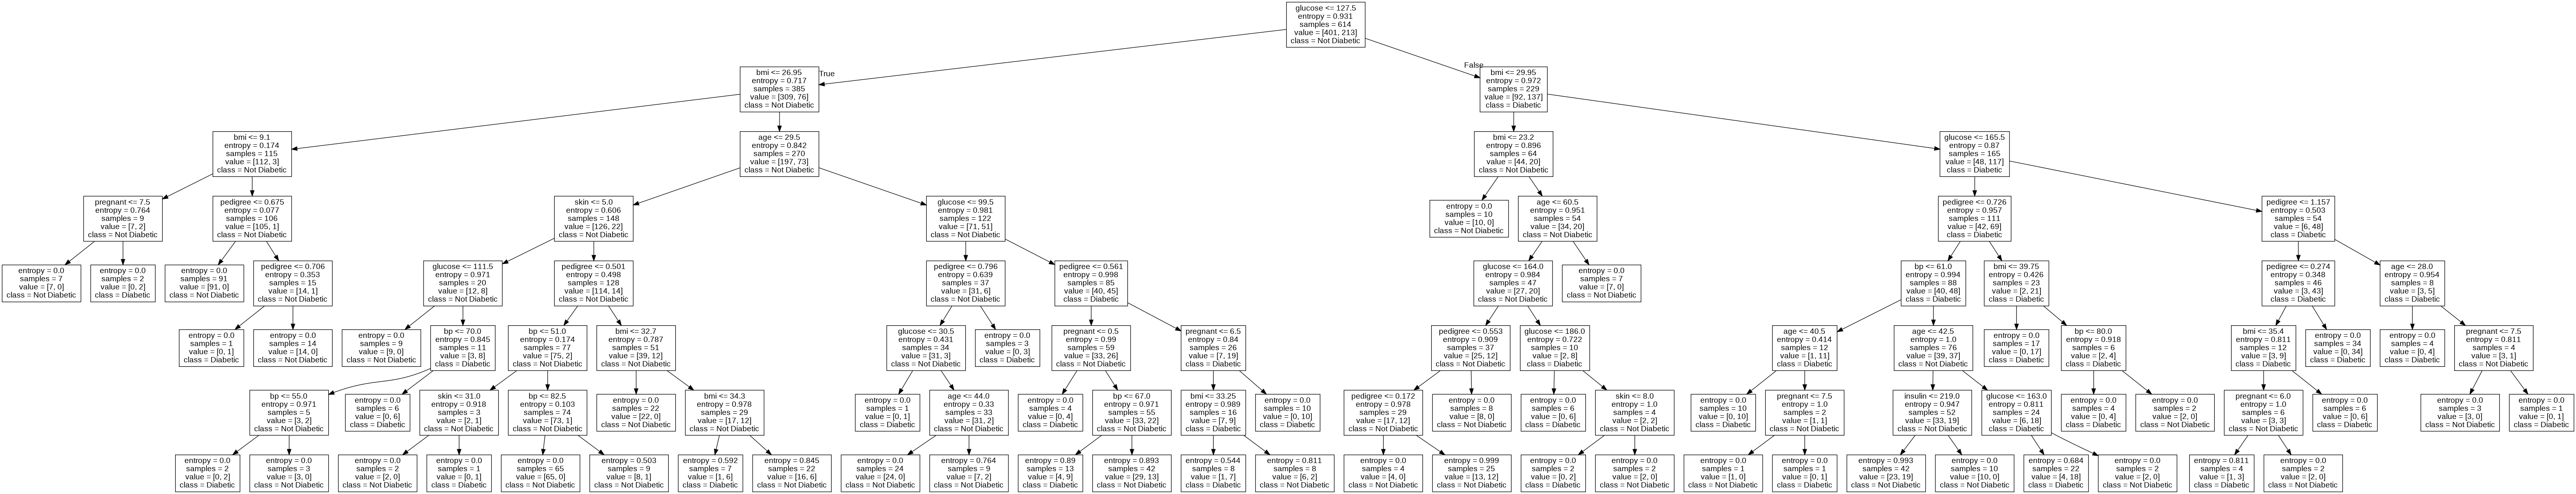

In [169]:
# import export_graphviz
from sklearn.tree import export_graphviz
# export files as stored as .dot files
dot_file = export_graphviz(model, feature_names=feature_names,
                           class_names= ['Not Diabetic', 'Diabetic'])

# import graphviz to convert .dot file to a .png image
import graphviz
# read the dot_file
graph = graphviz.Source(dot_file)
# convert .dot to .png without generating additional files
graph.render(filename='tree_diabetes', format='png', cleanup=True)

# import IPython to display the rendered .png image
from IPython.display import Image
# display image using the path
Image(filename="/content/tree_diabetes.png")

***Testing accuracy score*** raised from ***72% to 76%*** with just the first modification.

<a name='Conclusions'> </a>
# **Conclusions**
1. **GraphViz** allows to easily generate a visual representation of the Decision Tree which greatly helps in its ***interpretability***!

2. **Pre-Pruning** and **Post-Pruning** techniques were both successful to considerably ***increase testing accuracy*** and ***minimize overfitting*** with minimal modifications!